# WandB Dataset Visualization Demo

This notebook demostrates WandB's dataset visualization features. In particular we will show how WandB Artifacts can be used to visualize datasets and predictions, with a focus on specifically on image data. We will track model and data lineage as well as perform interactive model analysis on the resulting datasets. The overall flow will be:
1. Create a dataset
2. Split the dataset into train and test
3. Train a model to make predictions on the transformed dataet
4. Log predications from the model against training and evaluation sets
5. Analyze the model in WandB's UI

In [1]:
!pip install -r requirements.txt -U > /dev/null
!pip install -e ~/workspace/wandb-client -U

You should consider upgrading via the '/Users/timothysweeney/.pyenv/versions/3.8.6/envs/dsviz-demo-3.8/bin/python -m pip install --upgrade pip' command.
Obtaining file:///Users/timothysweeney/workspace/wandb-client
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Attempting uninstall: wandb
    Found existing installation: wandb 0.10.11.dev1
    Uninstalling wandb-0.10.11.dev1:
      Successfully uninstalled wandb-0.10.11.dev1
  Running setup.py develop for wandb
You should consider upgrading via the '/Users/timothysweeney/.pyenv/versions/3.8.6/envs/dsviz-demo-3.8/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import time
os.environ["WANDB_BASE_URL"] = "http://api.wandb.test"
WANDB_PROJECT = "wandb_dv_demo_" + str(time.time())

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import wandb
import util
util.clean_artifacts_dir()

## Download the Dataset
Before we get started, we will download an example dataset to our local machine. This is a big dataset, so please be patient if you are on a slow connection. For brevity, we put utility functions for working with the dataset in `util.py`. After the download is complete, we will show an example of the data.

Raw data downlaoded to ./bdd100k.


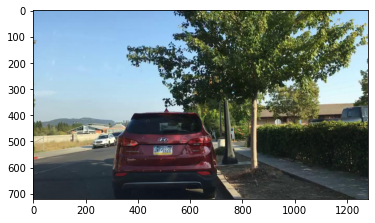

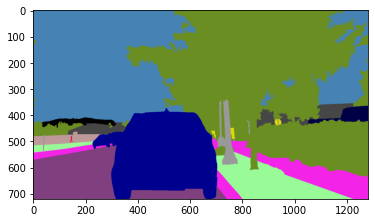

Class Mapping:
[(0, 'road'), (1, 'sidewalk'), (2, 'building'), (3, 'wall'), (4, 'fence'), (5, 'pole'), (6, 'traffic light'), (7, 'traffic sign'), (8, 'vegetation'), (9, 'terrain'), (10, 'sky'), (11, 'person'), (12, 'rider'), (13, 'car'), (14, 'truck'), (15, 'bus'), (16, 'train'), (17, 'motorcycle'), (18, 'bicycle'), (255, 'void')]


In [4]:
# Download the data if not already
util.download_data()
# Show an example training image
util.show_image(util.get_train_image_path(0))
# Show an example of color mask
util.show_image(util.get_color_label_image_path(0))

# Print the label types:
print("Class Mapping:")
print(list(zip(util.BDD_IDS, util.BDD_CLASSES)))

## Step 1: Create training and test datasets
First, let's build a dataset for use in the rest of this project. We will do this in the context of a `wandb.Run`. A Run is an isolated process which can optionally depend on upstream artifacts as well as optionally produce artifacts for later consumption. In this step, we will create a `wandb.Table` during our run and output it in an artifact. This table will contain all of our raw data for later use. Moreover, W&B offers rich tools to analyze and visualize such Tables in the interactive UI.

In [5]:
# Initialize the run
with wandb.init(
    project=WANDB_PROJECT,       # The project to register this Run to
    job_type="create_dataset",   # The type of this Run. Runs of the same type can be grouped together in the UI
    config={                     # Custom configuration parameters which you might want to tune or adjust for the Run
        "num_examples": 100,      # The number of raw samples to include.
        "scale_factor": 2        # The scaling factor for the images
    }) as run:

    # Setup a WandB Classes object. This will give additional metadata for visuals
    class_set = wandb.Classes([
        {'name': name, 'id': id} 
        for name, id in zip(util.BDD_CLASSES, util.BDD_IDS)
    ])
    
    # Setup a WandB Table object to hold our dataset
    table = wandb.Table(
        columns=["id", "train_image", "colored_image", "label_mask", "dominant_class"]
    )
    
    # Fill up the table
    for ndx in range(run.config["num_examples"]):
        
        # First, we will build a wandb.Image to act as our raw example object
        #    classes: the classes which map to masks and/or box metadata
        #    masks: the mask metadata. In this case, we use a 2d array where each cell corresponds to the label (this comes directlyfrom the dataset)
        #    boxes: the bounding box metadata. For example sake, we create bounding boxes by looking at the mask data and creating boxes which fully encolose each class.
        #           The data is an array of objects like:
        #                 "position": {
        #                             "minX": minX,
        #                             "maxX": maxX,
        #                             "minY": minY,
        #                             "maxY": maxY,
        #                         },
        #                         "class_id" : id_num,          
        #                     }
        example = wandb.Image(
            util.get_scaled_train_image(ndx, run.config.scale_factor),
            classes = class_set, 
            masks = {
                "ground_truth": {
                    "mask_data": util.get_scaled_mask_label(ndx, run.config.scale_factor)
                },
            }, 
            boxes={
                "ground_truth": {
                    "box_data": util.get_scaled_bounding_boxes(ndx, run.config.scale_factor)
                }
            }
        )
        
        # Next, we create two additional images which may be helpful during analysis. Notice that the additional metadata is optional.
        color_label = wandb.Image(util.get_scaled_color_mask(ndx, run.config.scale_factor))
        label_mask = wandb.Image(util.get_scaled_mask_label(ndx, run.config.scale_factor))
        
        # Finally, we add a row of our newly constructed data.
        table.add_data(util.train_ids[ndx], example, color_label, label_mask, util.get_dominant_class(label_mask))
    
    # Create an Artifact (versioned folder)
    artifact = wandb.Artifact(name="raw_data", type="dataset")
    
    # add the table to the artifact
    artifact.add(table, "raw_examples")
    
    # Finally, log the artifact
    run.log_artifact(artifact)
                       
    print("Saving data to WandB...")
print("... Run Complete")

wandb: Currently logged in as: new-team (use `wandb login --relogin` to force relogin)


wandb: Adding directory to artifact (/var/folders/wv/j7nq4t9j7tl2cq_2mz2mhbj40000gn/T/tmpyk3f9cgq)... Done. 0.0s


Saving data to WandB...


... Run Complete


### Step 1 Review:

Great, now if you click on th URL above, you should land on a run page. Since we did not log any metrics, there are no charts. Click the database icon on the left panel to see this run's artifacts. You should see something similar to the following:

![Raw Data](./notebook_images/raw_data.png)

Click on the "raw_data" row and navigate to the "Files" table. It should look like this:

![Raw Data](./notebook_images/raw_data_files.png)

Clicking on the "raw_examplse.table.json" entry will launch an interactive data explorer to review the table we just built:

![Raw Data](./notebook_images/raw_data_explore.png)


## Step 2: Splitting the data
Next, like any good practitioner, we will split the data into a train and test dataset. Similar to before, we will launch a Run to perform this operation. Remember, this new execution could happen on a different machine as we will dyanmically load the needed resources. In particular, we will laod in the raw dataset from the last run, and output 2 new datasets.


Example Data row
 ['04a328c5-7d9c636f', <wandb.data_types.Image object at 0x122049e80>, <wandb.data_types.Image object at 0x122940130>, <wandb.data_types.Image object at 0x1229405e0>, 'vegetation']

Example Image



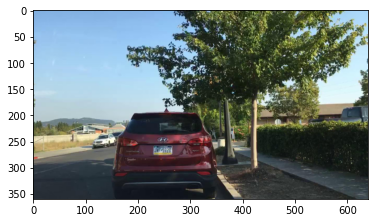


Artifact Directory Contents: 
 ['raw_data:v0']


wandb: Adding directory to artifact (/var/folders/wv/j7nq4t9j7tl2cq_2mz2mhbj40000gn/T/tmp00w32h_a)... Done. 0.0s
wandb: Adding directory to artifact (/var/folders/wv/j7nq4t9j7tl2cq_2mz2mhbj40000gn/T/tmppc0ofcak)... Done. 0.0s


Saving data to WandB...


... Run Complete


In [6]:
# This step should look familiar by now:
with wandb.init(
    project=WANDB_PROJECT, 
    job_type="split_dataset",
    config = {
        "train_pct": 0.7,
    }
) as run:
    
    # Get the latest version of the artifact. Notice the name alias follows this convention: "<ARTIFACT_NAME>:<VERSION>"
    # when version is set to "latest", then the latest version will always be used. However, you can pin to a version by
    # using an alias such as "raw_data:v0"
    dataset_artifact = run.use_artifact("raw_data:latest")
    
    # Next, we "get" the table by the same name that we saved it in the last run.
    data_table = dataset_artifact.get("raw_examples")
    
    # Print a row
    print("\nExample Data row\n", data_table.data[0])
    
    # Show an example image
    print("\nExample Image\n")
    plt.imshow(data_table.data[0][1]._image)
    plt.show()
    
    # Notice that a new directory was made: artifacts which is managed by wandb
    print("\nArtifact Directory Contents: \n", os.listdir("artifacts"))
    
    # Now we can build two separate artifacts for later use. We will first split the raw table into two parts,
    # then create two different artifacts, each of which will hold our new tables. We create two artifacts so that
    # in future runs, we can selectively decide which subsets of data to download.
    
    # Create the tables
    train_count = int(len(data_table.data) * run.config.train_pct)
    train_table = wandb.Table(columns=data_table.columns, data=data_table.data[:train_count])
    test_table = wandb.Table(columns=data_table.columns, data=data_table.data[train_count:])
    
    # Create the artifacts
    train_artifact = wandb.Artifact("train_data", "dataset")
    test_artifact = wandb.Artifact("test_data", "dataset")
    
    # Save the tables to the artifacts
    train_artifact.add(train_table, "train_table")
    test_artifact.add(test_table, "test_table")
    
    # Log the artifacts out as outputs of the run
    run.log_artifact(train_artifact)
    run.log_artifact(test_artifact)
    
    print("Saving data to WandB...")
print("... Run Complete")

### Step 2: Review
Notice, in this step, the raw_data `wandb.Table` was reinstatiated and the data, images, etc... came along for the ride. This makes it easy for practicioners to share data and assets easily. To manage this, you can see that we created an artifacts directory to save local data.

Now we have two new datasets. Feel free to browse them similar to our last step. However, this time, click "Graph View" rather than "Files" to see the lineage of the artifact:

![](./notebook_images/split_data.png)

![](./notebook_images/split_graph.png)

We will come back to this graph view later on!

## Step 3: Model Training
Now we will train a model to predict bounding boxes. For the sake of simplicity, we will "train" a model which splits the image into it's graysscale quantiles and assigns labels to each patch. As you can imagine, the model performance can be improved dramatically.

In [7]:
# Again, create a run.
with wandb.init(project=WANDB_PROJECT, job_type="model_train") as run:
    
    # Similar to before, we will load in the artifact and asset we need. In this case, the training data
    train_artifact = run.use_artifact("train_data:latest")
    train_table = train_artifact.get("train_table")
    
    # Next, we split out the labels and train the model
    train_data, mask_data = util.make_datasets(train_table, util.n_classes)
    model = util.ExampleSegmentationModel(util.n_classes)
    model.train(train_data, mask_data)
    
    # Finally we score the model. Behind the scenes, we score each mask on it's IOU score.
    scores, results = util.score_model(model, train_data, mask_data, util.n_classes)
    
    # Let's create a new table. Notice that we create many columns - an evaluation score for each class type.
    results_table = wandb.Table(
        columns = ["id", "pred_mask", "dominant_pred"] + util.BDD_CLASSES,
        
        # Data construction is similar to before, but we now use the predicted masks and bound boxes.
        data=[
        [train_table.data[ndx][0],
         wandb.Image(train_table.data[ndx][1], masks={
            "train_predicted_truth": {
                "mask_data": results[ndx],
            },
        }, boxes={
            "ground_truth": {
                "box_data": util.mask_to_bounding(results[ndx])
            }
        }),
        util.BDD_CLASSES[util.get_dominant_id_ndx(results[ndx])],
        ] + list(row)
        for ndx, row in enumerate(scores)
    ])
    
    # We create an artifact, add the table, and log it as part of the run.
    results_artifact = wandb.Artifact("train_results", "dataset")
    results_artifact.add(results_table, "train_iou_score_table")
    run.log_artifact(results_artifact)
    
    # Finally, let's save the model as a flat file and add that to it's own artifact.
    model.save("model.pkl")
    model_artifact = wandb.Artifact("trained_model", "model")
    model_artifact.add_file("model.pkl")
    run.log_artifact(model_artifact)
    
    print("Saving data to WandB...")
print("... Run Complete")

/Users/timothysweeney/workspace/dsviz-demo/util.py:149: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(((mask_a == class_id) & (mask_b == class_id)).sum(axis=(1,2)) / ((mask_a == class_id) | (mask_b == class_id)).sum(axis=(1,2)), 0, 0, 0)
wandb: Adding directory to artifact (/var/folders/wv/j7nq4t9j7tl2cq_2mz2mhbj40000gn/T/tmp2u8jgsa4)... Done. 0.0s


Saving data to WandB...


... Run Complete


## Step 4: Model Evaluation
Now that we have a trained model, we want to score it on the test data which was held out in step 2. This code is very similar to the training step, with the execption of slightly different naming. The important difference is that we load the saved model from the artifact.

In [8]:
with wandb.init(project=WANDB_PROJECT, job_type="model_eval") as run:
    
    # Retrieve the test data
    test_artifact = run.use_artifact("test_data:latest")
    test_table = test_artifact.get("test_table")
    test_data, mask_data = util.make_datasets(test_table, util.n_classes)
    
    # Download the saved model file.
    model_artifact = run.use_artifact("trained_model:latest")
    path = model_artifact.get_path("model.pkl").download()
    
    # Load the model from the file and score it
    model = util.ExampleSegmentationModel.load(path)
    scores, results = util.score_model(model, test_data, mask_data, util.n_classes)
    
    # Create a predicted score table similar to step 3.
    results_artifact = wandb.Artifact("test_results", "dataset")
    data = [
        [test_table.data[ndx][0], 
         wandb.Image(test_table.data[ndx][1], masks={
            "test_predicted_truth": {
                "mask_data": results[ndx],
            },
        }, boxes={
            "ground_truth": {
                "box_data": util.mask_to_bounding(results[ndx])
            }
        }),
        util.BDD_CLASSES[util.get_dominant_id_ndx(results[ndx])],
        ] + list(row)
        for ndx, row in enumerate(scores)
    ]
    
    # And log out the results.
    results_artifact.add(wandb.Table(["id", "pred_mask_test", "dominant_pred_test"] + util.BDD_CLASSES, data=data), "test_iou_score_table")
    run.log_artifact(results_artifact)

wandb: Adding directory to artifact (/var/folders/wv/j7nq4t9j7tl2cq_2mz2mhbj40000gn/T/tmpml_kzisd)... Done. 0.0s


## Step 5: Model Analysis
This is where it all comes together. In this step, we join the train and test scoring results with the original dataset and output corresponding artifacts. The new idea introduced here is a `wandb.JoinTable` which allows you to join two Tables for further analysis in the UI.

In [9]:
with wandb.init(project=WANDB_PROJECT, job_type="model_result_analysis") as run:
    
    # Retrieve the original raw dataset
    dataset_artifact = run.use_artifact("raw_data:latest")
    data_table = dataset_artifact.get("raw_examples")
    
    # Retrieve the train and test score tables
    train_artifact = run.use_artifact("train_results:latest")
    train_table = train_artifact.get("train_iou_score_table")
    
    test_artifact = run.use_artifact("test_results:latest")
    test_table = test_artifact.get("test_iou_score_table")
    
    # Join the tables on ID column and log them as outputs.
    train_results = wandb.JoinedTable(train_table, data_table, "id")
    test_results = wandb.JoinedTable(test_table, data_table, "id")
    artifact = wandb.Artifact("summary_results", "dataset")
    artifact.add(train_results, "train_results")
    artifact.add(test_results, "test_results")
    run.log_artifact(artifact)

wandb: Adding directory to artifact (/var/folders/wv/j7nq4t9j7tl2cq_2mz2mhbj40000gn/T/tmpc208rx8p)... Done. 0.0s


### Step 5: Review
Now, click on the above **Project** page (second link). This will look like the following:

![](./notebook_images/project_page.png)

Click on the database icon as you have done before to see the artifacts. This time, you are seeing the artifacts for th entire project, with counts of their versions:

![](./notebook_images/project_artifacts.png)

Go ahead and click the "model" artifact type, "Files", and "model.pkl". The viewer will provide different renderings based on the file type. For a pickled class, you get the following image. For Deep Nets, you can see all the layers and their attributes.

![](./notebook_images/model_view.png)

Next, head back to the artifact page, click Database type, expand summary_results, and select your most recent version. Click "Files" and select one of the join tables:

![](./notebook_images/join_view.png)

Exploring a bit, you can toggle the bounding boxes, masks, group, filter, and sort the data:

![](./notebook_images/summary_join.png)

![](./notebook_images/grouped.png)

Finally, click graph view, and "explode". Now, you can visualize the entire process end-to-end:

![](./notebook_images/summary_graph.png)